In [1]:
import os
os.chdir('../../')

In [3]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Mon Mar 31 13:51:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:19:00.0 Off |                  Off |
|  0%   57C    P8             39W /  450W |      11MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### from "sample pair.ipynb"

In [4]:
import torch
import torch.nn.functional as F

total_samples = 256
save_file = f'/data/optimization/euler_NFE=1000_N={total_samples}_imagenet128.pt'
data = torch.load(save_file)
noise = data['pairs'][:, 0]
target = data['pairs'][:, 1]
classes = data['classes']
print(noise.shape, target.shape)
print(classes)

torch.Size([256, 3, 128, 128]) torch.Size([256, 3, 128, 128])
tensor([348, 940, 965,  52,  47, 108, 901, 711, 168, 530,  67, 646, 855, 978,
         50, 578, 139, 527, 885, 979, 462, 100, 769, 805,  16, 501, 669, 560,
        276, 842, 946, 677, 354, 595, 792,  18, 394, 386, 345, 305, 854, 598,
        112, 851, 578, 720, 420, 136, 637, 929, 800, 921, 418, 549, 142, 929,
        178, 912, 738, 614, 243, 282, 646, 644, 174,  97, 567, 455, 766, 208,
        414, 152, 566, 621, 303, 891, 571, 361, 274, 159, 797, 125, 906, 163,
        348,  70, 361, 347, 186, 713, 204, 742, 578, 288, 354, 620, 959, 823,
        327, 358,  46, 860, 144, 402, 447,  99, 421, 623, 868, 140, 953, 670,
        184, 670, 993, 239, 907, 178, 377,  11, 803, 917, 338, 567, 217, 568,
        101, 368, 897, 571,  43, 639, 594, 764, 576, 992, 771, 734, 850, 814,
        538, 493,  67, 893, 909, 564, 210, 120, 779, 750, 386, 209, 976, 333,
        405, 886, 674, 598, 139, 615, 538,  54, 651, 264,  97, 870, 335,  71,
  

In [17]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random

from main import parse_args_and_config, Diffusion
from datasets import inverse_data_transform

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.benchmark = False

###############################################################################
# 1) Notebook에서 sys.argv를 직접 설정 (argparse 흉내)
###############################################################################
sys.argv = [
    "main.py",
    "--config", "imagenet128_guided.yml",  # 사용하려는 config
    "--sample",
    "--eta", "0",
    "--dpm_solver_type", "data_prediction",
    "--dpm_solver_order", "3",
    "--skip_type", "logSNR",
    "--scale", "0.0",
    "--thresholding",
    "--ni",

    "--sample_type", "rbfsolverglq10laggrid",
    "--timesteps", "20",
    "--log_scale_min", "-2.0",
    "--log_scale_max", "3.0",
    "--log_scale_num", "33",
    "--scale_dir", "/data/data/rbfsolverglq10laggrid",
]

###############################################################################
# 2) 인자/설정 로드
###############################################################################
args, config = parse_args_and_config()

###############################################################################
# 3) Diffusion 객체 생성 -> 모델 로딩
###############################################################################
diffusion = Diffusion(args, config, rank=0)
diffusion.prepare_model()
diffusion.model.eval()

###############################################################################
# 4) 배치(25장) 한 번에 샘플링 -> 5x5 그리드(여백 없이) 시각화
###############################################################################
device = diffusion.device


INFO - main.py - 2025-03-31 13:55:08,601 - Using device: cuda
INFO - main.py - 2025-03-31 13:55:08,601 - Using device: cuda
INFO - main.py - 2025-03-31 13:55:08,601 - Using device: cuda
INFO - main.py - 2025-03-31 13:55:08,601 - Using device: cuda


[prepare_model] Model is ready.


In [18]:
!mkdir /data/data/rbfsolverglq10laggrid
!ls /data/data/rbfsolverglq10laggrid

mkdir: cannot create directory ‘/data/data/rbfsolverglq10laggrid’: File exists
'NFE=10,p=3,dataset=IMAGENET128.npy'  'NFE=20,p=3,dataset=IMAGENET64.npy'
'NFE=10,p=3,dataset=IMAGENET64.npy'   'NFE=5,p=3,dataset=IMAGENET128.npy'
'NFE=15,p=3,dataset=IMAGENET128.npy'  'NFE=5,p=3,dataset=IMAGENET64.npy'
'NFE=15,p=3,dataset=IMAGENET64.npy'


In [19]:
n = 64
noise_batch = noise[:n].to(device)
target_batch = target[:n].to(device)
print(noise_batch.shape)
(pred, optimal_log_scales, loss_grid_list), _ = diffusion.sample_image(noise_batch, diffusion.model, target=target_batch)
loss = F.mse_loss(pred, target_batch)
print(loss)

torch.Size([64, 3, 128, 128])
/data/data/rbfsolverglq10laggrid/NFE=20,p=3,dataset=IMAGENET128.npy  saved!
tensor(0.0959, device='cuda:0')


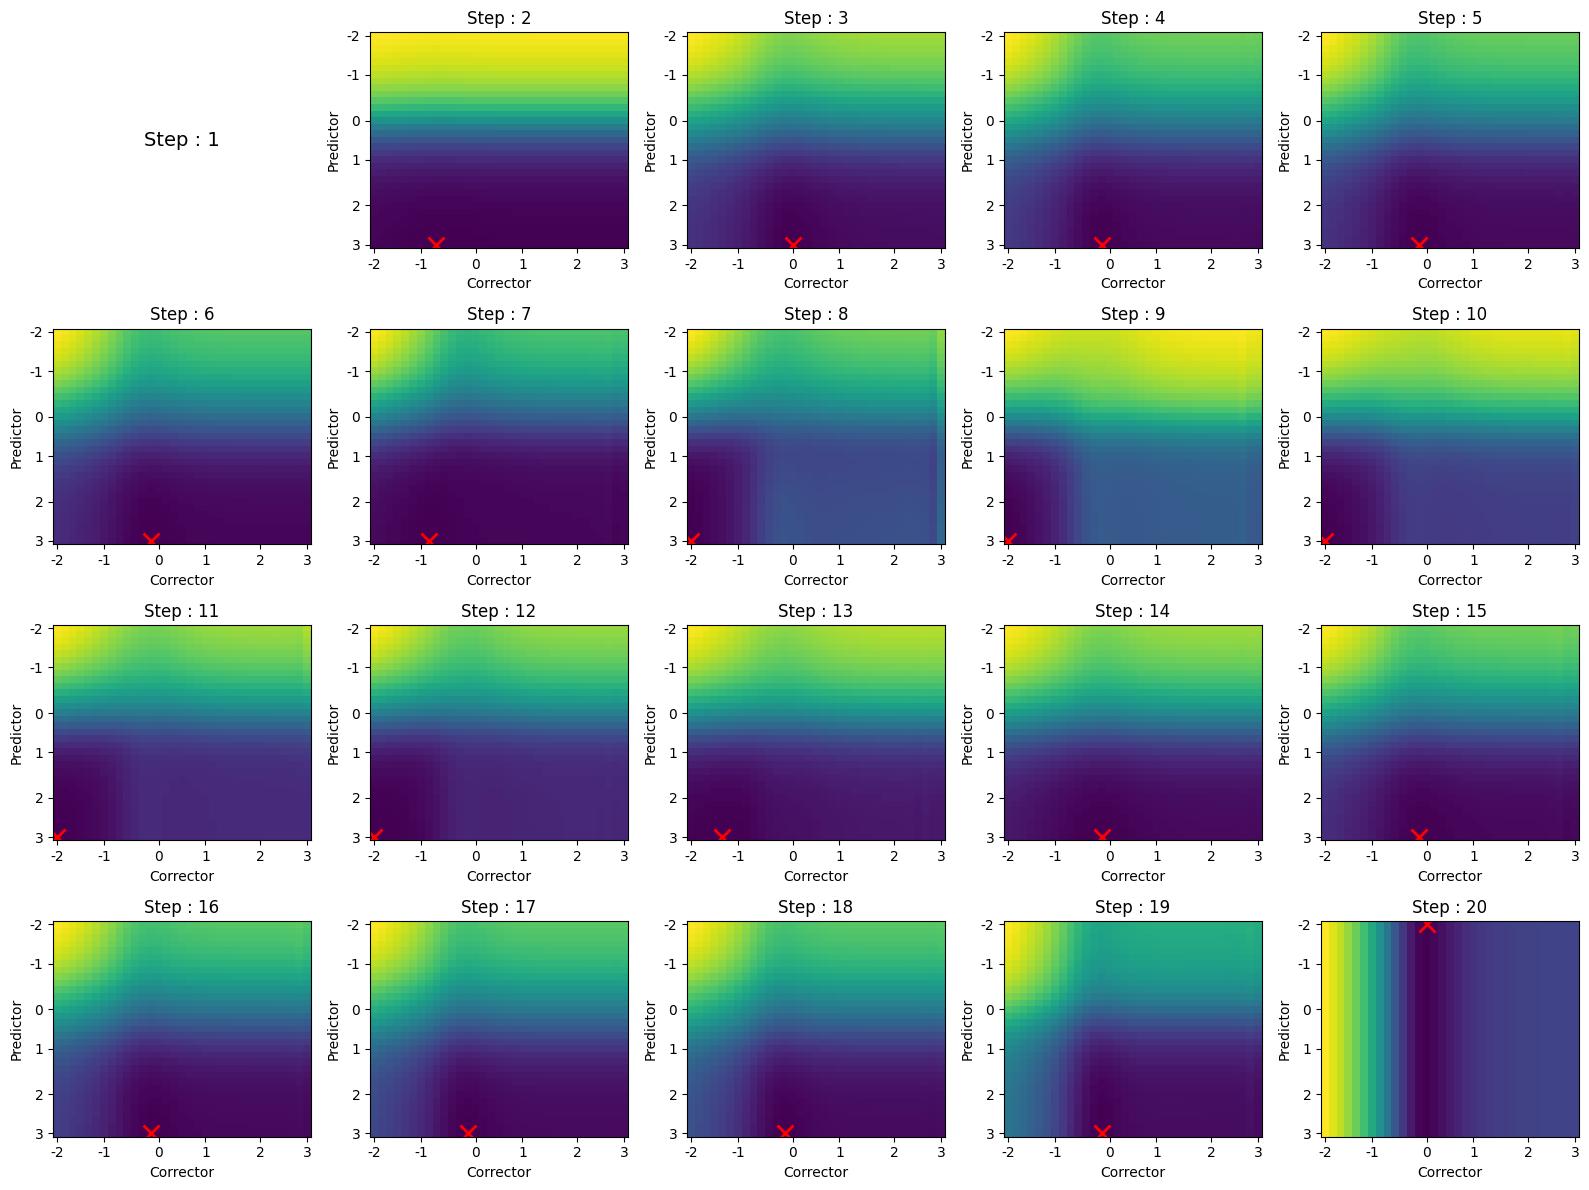

In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_grid_list(loss_grid_list, args):
    """
    subplot (num_rows x num_cols)에서 (0,0)은 비워두고 'Step : 1' 표시,
    나머지 (0,1)부터 순차적으로 loss_grid를 그립니다.
    x축, y축 값은 log_scale_min ~ log_scale_max 사이의 '정수'에 해당하는 지점만 표기합니다.
    """
    num_plots = len(loss_grid_list)
    num_cols = 5
    num_rows = math.ceil(num_plots / num_cols)
    
    # 축 레이블용 값 (linspace)
    axis = np.linspace(args.log_scale_min, args.log_scale_max, args.log_scale_num)
    
    # figure, axes 생성
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 3 * num_rows))
    
    # axes 2차원 보장
    if num_rows == 1 and num_cols == 1:
        axes = np.array([[axes]])
    elif num_rows == 1 or num_cols == 1:
        axes = axes.reshape(num_rows, num_cols)
    
    # ------------------------
    # (0,0)을 비우고, 중앙에 'Step : 1' 표시
    # ------------------------
    ax_empty = axes[0, 0]
    ax_empty.set_axis_off()
    ax_empty.text(0.5, 0.5, "Step : 1", fontsize=14,
                  ha='center', va='center', transform=ax_empty.transAxes)
    
    # ------------------------
    # x축, y축에서 찍을 '정수' 목록과 해당 인덱스 찾기
    # ------------------------
    # 예: log_scale_min=-1, log_scale_max=2 라면, -1~2 정수 => -1,0,1,2
    start_int = int(math.floor(args.log_scale_min))
    end_int   = int(math.ceil(args.log_scale_max))
    
    x_indices = []
    x_labels  = []
    y_indices = []
    y_labels  = []
    
    # x축 / y축이 같은 axis라서 로직은 동일
    for int_val in range(start_int, end_int + 1):
        # axis에서 이 int_val에 가장 가까운 인덱스를 찾음
        idx = np.argmin(np.abs(axis - int_val))
        
        # x, y 둘 다 같은 방식으로 추가
        x_indices.append(idx)
        x_labels.append(str(int_val))
        
        y_indices.append(idx)
        y_labels.append(str(int_val))
    
    # 이제 (0,1)부터 loss_grid 시각화
    max_subplots = num_rows * num_cols
    
    for i, loss_grid in enumerate(loss_grid_list):
        subplot_index = i + 1  # (0,0)은 비웠으므로
        
        if subplot_index >= max_subplots:
            print("Warning: subplot 갯수 초과. 일부 데이터는 표시되지 않습니다.")
            break
        
        row = subplot_index // num_cols
        col = subplot_index % num_cols
        
        ax = axes[row, col]
        ax.set_title(f"Step : {i + 2}")
        
        # 히트맵
        im = ax.imshow(loss_grid, aspect='auto', interpolation='nearest')
        
        # X축, Y축에 '정수' 인덱스만 표시
        ax.set_xticks(x_indices)
        ax.set_xticklabels(x_labels)
        ax.set_yticks(y_indices)
        ax.set_yticklabels(y_labels)
        
        ax.set_xlabel("Corrector")
        ax.set_ylabel("Predictor")
        
        # 최소값 위치 표시
        min_idx = np.argmin(loss_grid)
        min_row, min_col = np.unravel_index(min_idx, loss_grid.shape)
        ax.plot(min_col, min_row, 'x', markersize=12, markeredgewidth=2, color='red')
        
        # 필요 시 컬러바
        # fig.colorbar(im, ax=ax, format='%.3f')

    plt.tight_layout()
    plt.show()

plot_loss_grid_list(loss_grid_list, args)
